In [1]:
# Cell 1: imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, auc
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

In [2]:
# Cell 2: load
df = pd.read_csv('creditcard.csv')
print('shape:', df.shape)
print(df['Class'].value_counts())
# quick view
df.head()

shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Cell 3: preprocessing
X = df.drop('Class', axis=1)
y = df['Class']
# Scale Time & Amount (V1..V28 already scaled)
scaler = StandardScaler()
X[['Time','Amount']] = scaler.fit_transform(X[['Time','Amount']])
# stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('Train size', X_train.shape, 'Test size', X_test.shape)

Train size (227845, 30) Test size (56962, 30)


In [7]:
# Cell 4: IsolationForest
iso = IsolationForest(n_estimators=200, contamination= (y.sum()/len(y)), random_state=RANDOM_STATE)
iso.fit(X_train)
iso_pred_test = iso.predict(X_test) # 1 (inlier) or -1 (outlier)
iso_pred_test_binary = np.where(iso_pred_test == -1, 1, 0)


# Local Outlier Factor (novelty mode to predict on test)
lof = LocalOutlierFactor(n_neighbors=20, contamination=(y.sum()/len(y)), novelty=True)
lof.fit(X_train)
lof_pred_test = lof.predict(X_test)
lof_pred_test_binary = np.where(lof_pred_test == -1, 1, 0)


# Quick evaluation for both
from sklearn.metrics import classification_report
print('IsolationForest report')
print(classification_report(y_test, iso_pred_test_binary, digits=4))
print('\nLOF report')
print(classification_report(y_test, lof_pred_test_binary, digits=4))

IsolationForest report
              precision    recall  f1-score   support

           0     0.9988    0.9986    0.9987     56864
           1     0.2804    0.3061    0.2927        98

    accuracy                         0.9975     56962
   macro avg     0.6396    0.6524    0.6457     56962
weighted avg     0.9976    0.9975    0.9975     56962


LOF report
              precision    recall  f1-score   support

           0     0.9983    0.9982    0.9983     56864
           1     0.0000    0.0000    0.0000        98

    accuracy                         0.9965     56962
   macro avg     0.4991    0.4991    0.4991     56962
weighted avg     0.9966    0.9965    0.9965     56962



In [8]:
# Cell 5: SMOTE
sm = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE) # frauds -> 10% of majority
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled:', y_res.value_counts())


# Train XGBoost
model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
model.fit(X_res, y_res)


# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred, digits=4))
print('ROC AUC:', roc_auc_score(y_test, y_proba))

Resampled: Class
0    227451
1     22745
Name: count, dtype: int64
              precision    recall  f1-score   support

           0     0.9998    0.9997    0.9997     56864
           1     0.8400    0.8571    0.8485        98

    accuracy                         0.9995     56962
   macro avg     0.9199    0.9284    0.9241     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC AUC: 0.9762023496089489


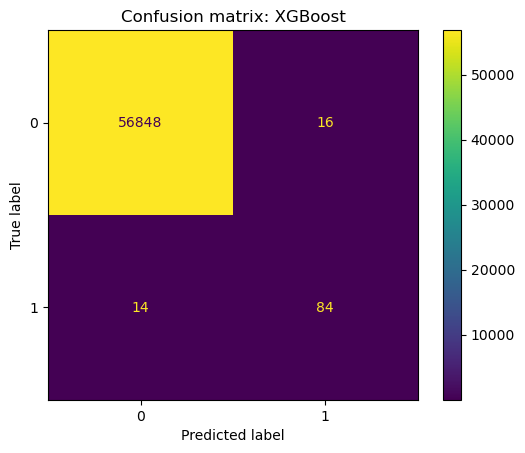

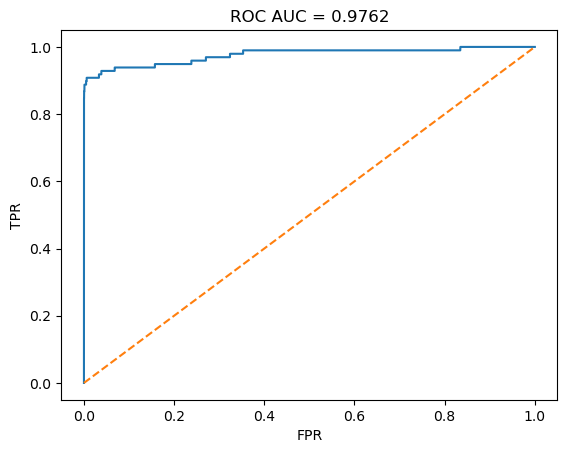

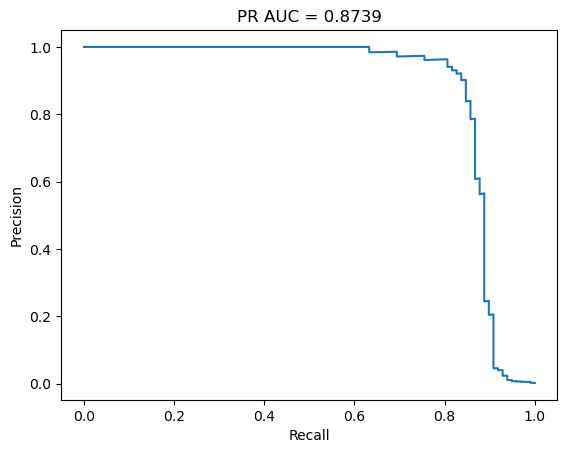

In [9]:
# Cell 6: Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title('Confusion matrix: XGBoost')
plt.show()


# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title(f'ROC AUC = {roc_auc:.4f}')
plt.show()


# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title(f'PR AUC = {pr_auc:.4f}')
plt.show()

In [10]:
# Cell 7: Save
joblib.dump(model, 'xgb_fraud_model.joblib')
joblib.dump(iso, 'isolation_forest.joblib')
joblib.dump(scaler, 'scaler.joblib')
print('Saved: xgb_fraud_model.joblib, isolation_forest.joblib, scaler.joblib')

Saved: xgb_fraud_model.joblib, isolation_forest.joblib, scaler.joblib
